In [12]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
!pip install newspaper3k
from newspaper import Article
from textblob import TextBlob
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
def fetch_data(ticker, period):
    stock = yf.Ticker(ticker)
    return stock.history(period=period)


def plot_stock(data, label, color):
    plt.plot(data.index, data['Close'], label=f"{label} Close Price", color=color)

def plot_normalized_data(data, ticker, color, subplot):
    rolling_mean = data["Close"].rolling(window=30).mean()
    normalized_data = data["Close"] / rolling_mean
    subplot.plot(data.index, normalized_data, label=ticker, color=color)
    subplot.set_title(f"Normalized Stock Prices for {ticker}")
    subplot.set_ylabel("Normalized Closing Price")

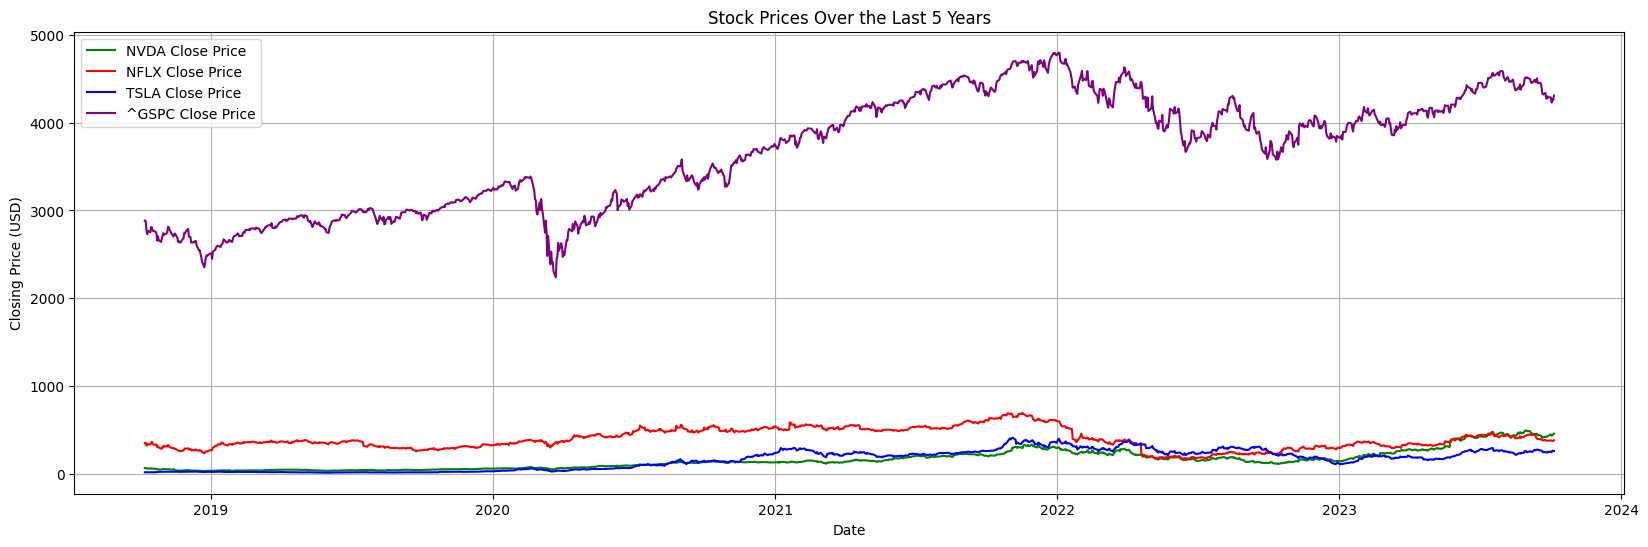

In [15]:
tickers = ["NVDA", "NFLX", "TSLA","^GSPC"]
colors = ["green", "red", "blue", "purple" ]
ticker_colors = {ticker: color for ticker, color in zip(tickers, colors)}
period = "5y"


plt.figure(figsize=(20, 6))

for ticker, color in zip(tickers, colors):
    stock_data = fetch_data(ticker, period)
    plot_stock(stock_data, ticker, color)

plt.title("Stock Prices Over the Last 5 Years")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

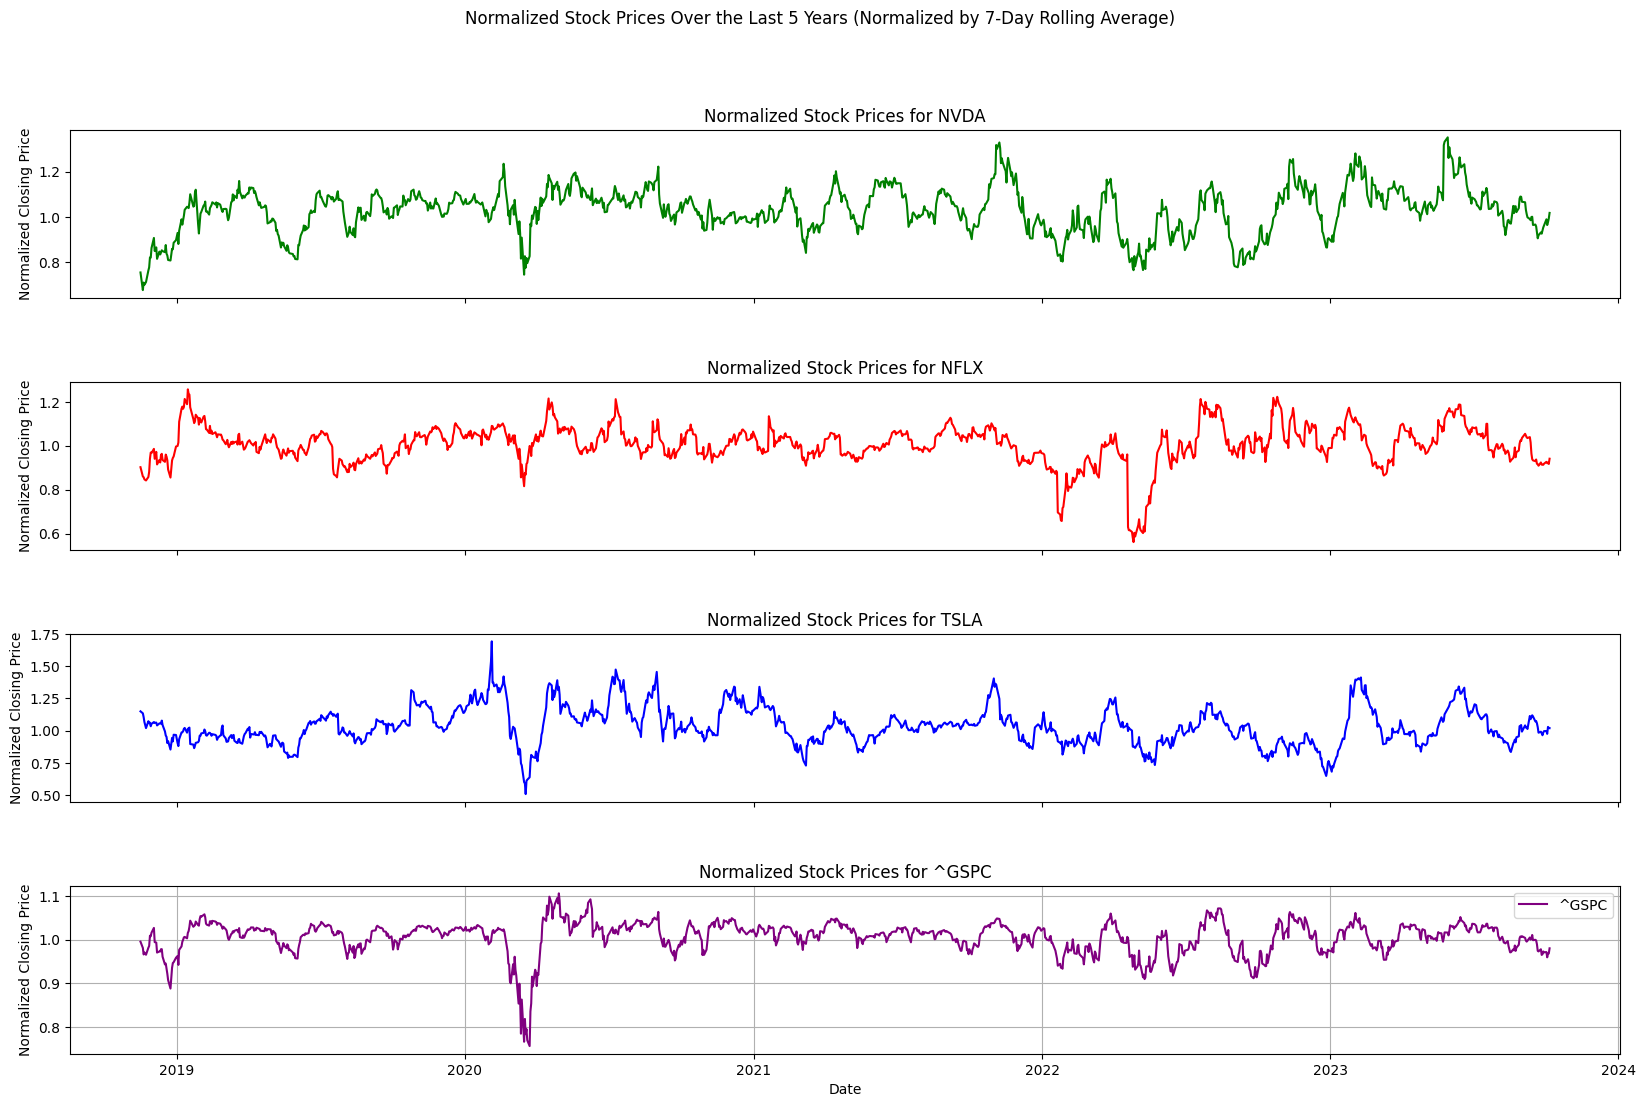

In [16]:
fig, axs = plt.subplots(len(tickers), 1, figsize=(20, 12), sharex=True)

for i, (ticker, color) in enumerate(zip(tickers, colors)):
    stock_data = fetch_data(ticker, period)
    plot_normalized_data(stock_data, ticker, color, axs[i])

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Normalized Stock Prices Over the Last 5 Years (Normalized by 7-Day Rolling Average)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

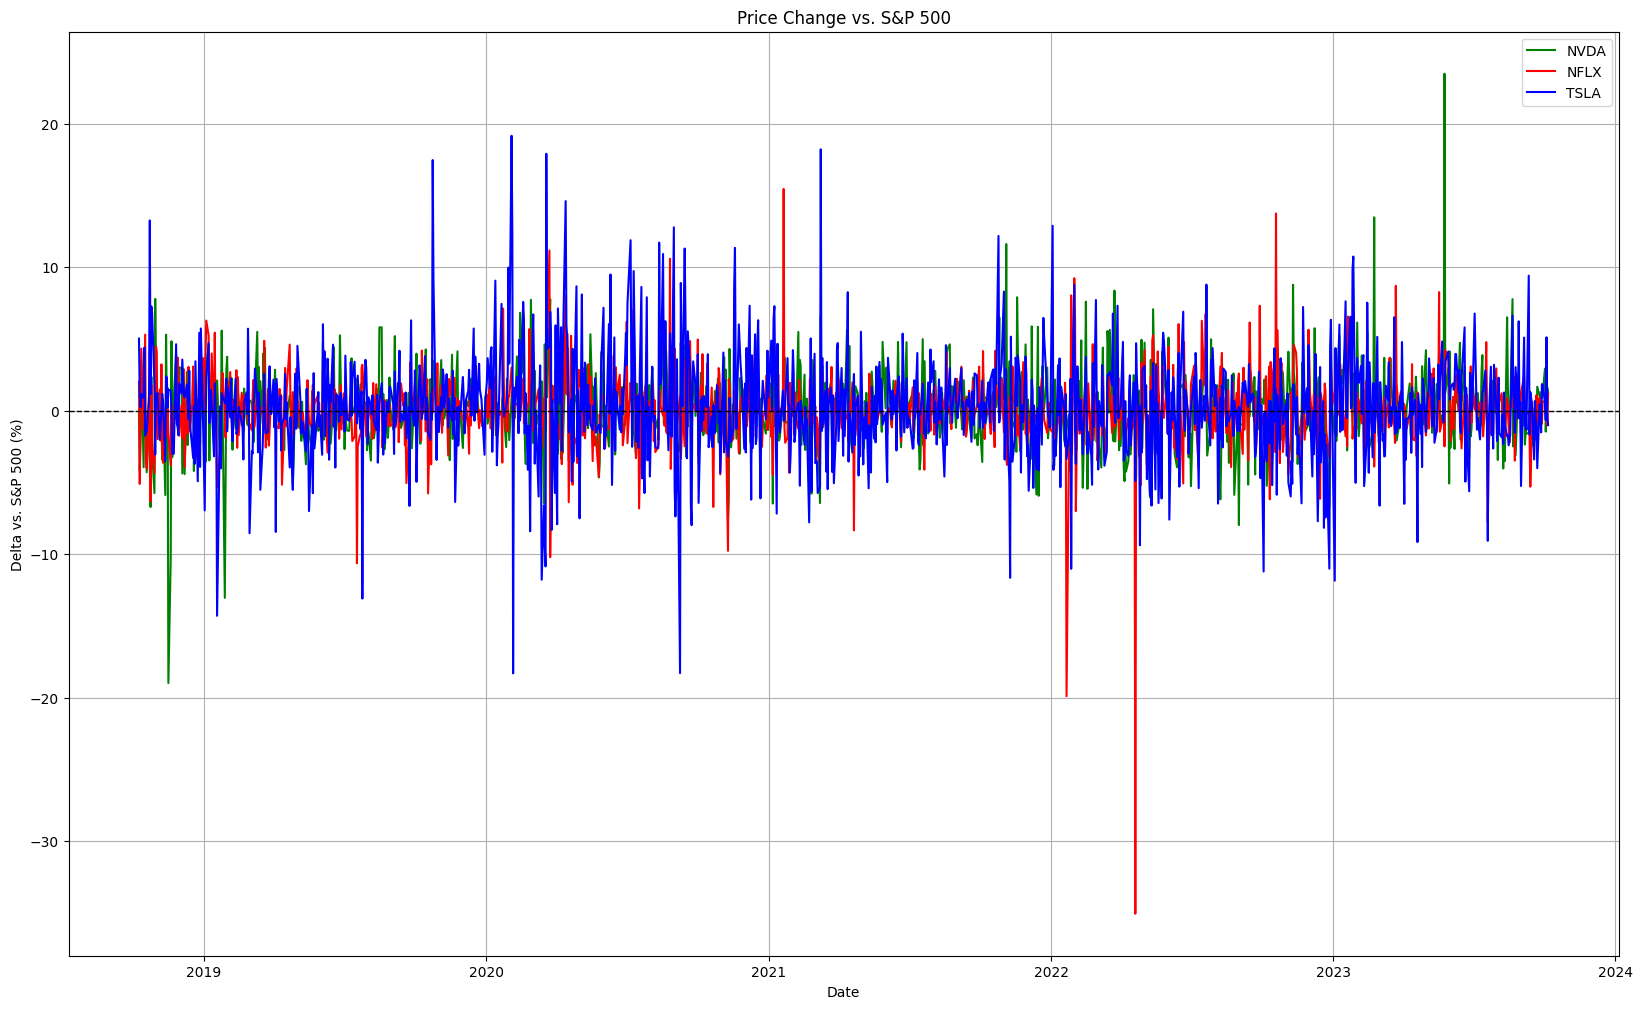

In [17]:
data = {}
for ticker in tickers:
    data[ticker] = fetch_data(ticker, period)

for ticker in data:
    data[ticker]['Delta'] = data[ticker]['Close'].pct_change() * 100


for ticker in tickers[:-1]:
    data[ticker]['Delta vs S&P 500'] = data[ticker]['Delta'] - data['^GSPC']['Delta']

plt.figure(figsize=(20, 12))
for ticker, color in zip(tickers[:-1], colors[:-1]):
    plt.plot(data[ticker].index, data[ticker]['Delta vs S&P 500'], label=ticker, color=color)

plt.title("Price Change vs. S&P 500")
plt.xlabel("Date")
plt.ylabel("Delta vs. S&P 500 (%)")
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.show()

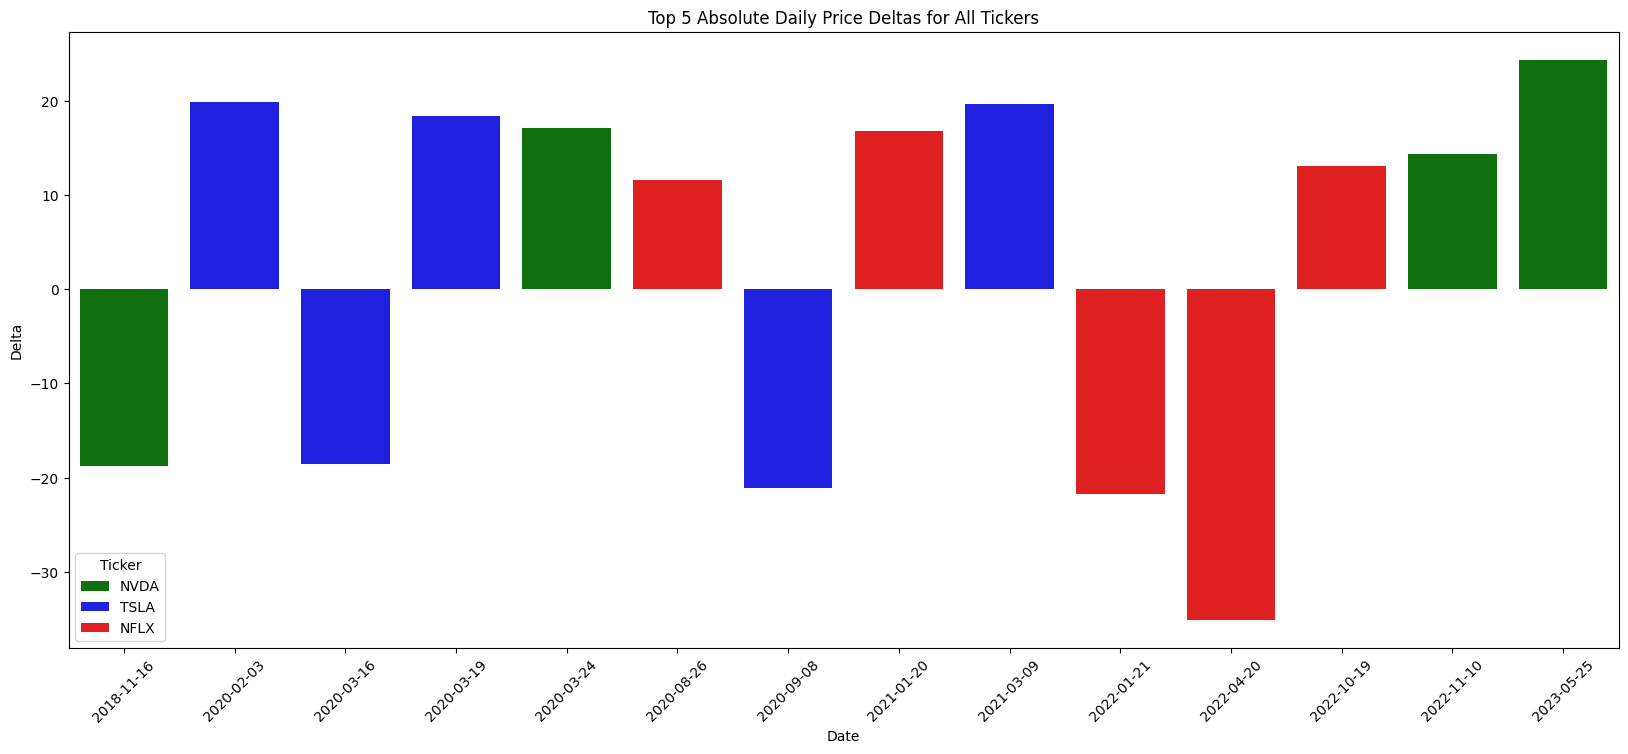

In [18]:
all_top_deltas = pd.DataFrame(columns=['Date', 'Delta', 'Ticker'])


for i, ticker in enumerate(tickers[:-1]):
    top_absolute_deltas = data[ticker]['Delta'].abs().nlargest(5)
    top_deltas_with_signal = data[ticker].loc[top_absolute_deltas.index]
    top_deltas_with_signal.sort_index(inplace=True)
    top_deltas_with_signal['Date'] = top_deltas_with_signal.index.strftime('%d-%m-%Y')
    top_deltas_with_signal['Ticker'] = ticker


    all_top_deltas = pd.concat([all_top_deltas, top_deltas_with_signal])


all_top_deltas['Date'] = pd.to_datetime(all_top_deltas['Date'], format='%d-%m-%Y')
all_top_deltas = all_top_deltas.sort_values(by=['Date', 'Delta'], ascending=[True, False])


all_top_deltas['Date'] = all_top_deltas['Date'].dt.date


plt.figure(figsize=(20, 8))
sns.barplot(x='Date', y='Delta', hue='Ticker', data=all_top_deltas, palette=ticker_colors, dodge=False)
plt.xlabel('Date')
plt.ylabel('Delta')
plt.title('Top 5 Absolute Daily Price Deltas for All Tickers')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.show()


In [26]:
columns_to_display = ['Ticker', 'Date', 'Open', 'Close', 'Delta']

all_top_deltas[columns_to_display] = all_top_deltas[columns_to_display].round(2)

print(all_top_deltas[columns_to_display].to_string(index=False))


Ticker       Date   Open  Close  Delta
  NVDA 2018-11-16  40.48  40.75 -18.76
  TSLA 2020-02-03  44.91  52.00  19.89
  NVDA 2020-03-16  52.93  48.94 -18.45
  TSLA 2020-03-16  31.30  29.67 -18.58
  TSLA 2020-03-19  24.98  28.51  18.39
  NVDA 2020-03-24  57.07  62.10  17.16
  NFLX 2020-08-26 492.50 547.53  11.61
  TSLA 2020-09-08 118.67 110.07 -21.06
  NFLX 2021-01-20 565.42 586.34  16.85
  TSLA 2021-03-09 202.73 224.53  19.64
  NFLX 2022-01-21 400.43 397.50 -21.79
  NFLX 2022-04-20 245.20 226.19 -35.12
  NFLX 2022-10-19 265.00 272.38  13.09
  NVDA 2022-11-10 147.91 157.40  14.33
  NVDA 2023-05-25 385.16 379.73  24.37


<ipython-input-28-05deafbf89d5>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Date"] = subset["Date"].dt.to_timestamp()


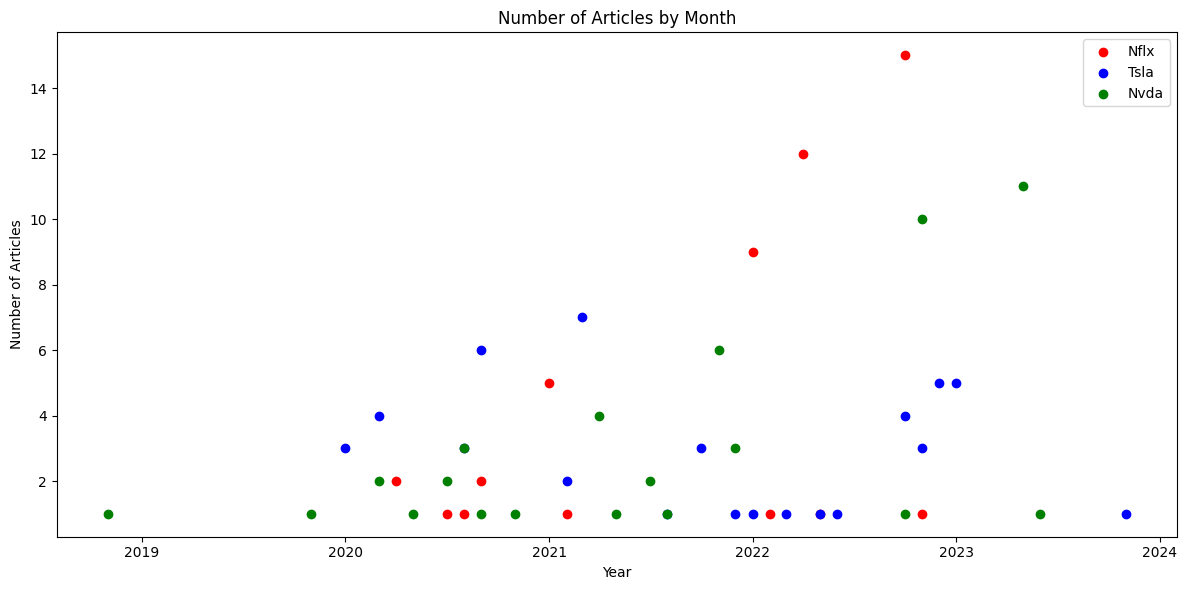

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt

file_paths = [
    "/content/drive/MyDrive/IA1/data/netflix.json",
    "/content/drive/MyDrive/IA1/data/tesla.json",
    "/content/drive/MyDrive/IA1/data/nvidia.json"
]

data_df = pd.DataFrame(columns=["Date", "Ticket", "Count"])


for file_path in file_paths:
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
        ticket = data["ticket"]
        articles = data["articles"]
        for article in articles:
            publish_date = article["publish_date"]
            data_df = data_df.append({"Date": publish_date, "Ticket": ticket}, ignore_index=True)


data_df["Date"] = pd.to_datetime(data_df["Date"], format="%m/%d/%Y")
grouped_data = data_df.groupby([data_df["Date"].dt.to_period("M"), "Ticket"]).size().reset_index(name="Count")

plt.figure(figsize=(12, 6))

colors = {"nflx": "red", "tsla": "blue", "nvda": "green"}
for ticket, color in colors.items():
    subset = grouped_data[grouped_data["Ticket"] == ticket]


    subset["Date"] = subset["Date"].dt.to_timestamp()

    plt.scatter(subset["Date"], subset["Count"], label=ticket.capitalize(), color=color)


plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("Number of Articles by Month")
plt.legend()


plt.tight_layout()
plt.show()